In [1]:
!pip install -U gdown

import gdown

# Extracted file ID from your link https://drive.google.com/file/d/1Gb8l9ezeUbHGzbg1Hj1IZGy7e754tG9D/view?usp=sharing
file_id = "1Gb8l9ezeUbHGzbg1Hj1IZGy7e754tG9D"
# Use gdown to download
gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.zip", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1Gb8l9ezeUbHGzbg1Hj1IZGy7e754tG9D
From (redirected): https://drive.google.com/uc?id=1Gb8l9ezeUbHGzbg1Hj1IZGy7e754tG9D&confirm=t&uuid=a0624f52-b709-46ad-a04c-82a1eb118eee
To: /content/data.zip
100%|██████████| 1.67G/1.67G [00:21<00:00, 77.0MB/s]


'data.zip'

In [2]:
import zipfile

zip_file_name = "data.zip"
extract_folder = "Pomegranate"

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Files extracted to: {extract_folder}")


Files extracted to: Pomegranate


In [3]:
import os
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import zipfile
import xml.etree.ElementTree as ET

In [4]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [16]:
# Define paths and hyperparameters
DATASET_PATH = "/content/Pomegranate/Pomegranate Images Dataset/VOC2007"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-3
MODEL_NAME = "tiny_vit_5m_224"
CLASSES = ['bud', 'flower', 'early-fruit', 'mid-growth', 'ripe']
NUM_CLASSES = len(CLASSES)
logger.info(f"Using device: {DEVICE}")

In [6]:
# Custom Dataset class
class PomegranateDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_dir = os.path.join(data_dir, 'JPEGImages')
        self.annot_dir = os.path.join(data_dir, 'Annotations')
        self.classes = CLASSES
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        # Collect image paths and labels
        try:
            for img_name in os.listdir(self.image_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(self.image_dir, img_name)
                    annot_path = os.path.join(self.annot_dir, os.path.splitext(img_name)[0] + '.xml')
                    if os.path.exists(annot_path):
                        tree = ET.parse(annot_path)
                        root = tree.getroot()
                        obj = root.find('object')
                        if obj is not None:
                            label = obj.find('name').text.lower()
                            if label in self.class_to_idx:
                                self.image_paths.append(img_path)
                                self.labels.append(self.class_to_idx[label])
                            else:
                                logger.warning(f"Label {label} not in classes: {img_path}")
                        else:
                            logger.warning(f"No object found in {annot_path}")
                    else:
                        logger.warning(f"Annotation not found for {img_path}")
            if not self.image_paths:
                raise ValueError("No valid images with annotations found")
            logger.info(f"Loaded {len(self.image_paths)} images across {len(set(self.labels))} classes")
        except Exception as e:
            logger.error(f"Error loading dataset: {str(e)}")
            raise

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            logger.warning(f"Error loading image {img_path}: {str(e)}")
            return None, None


In [7]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [8]:
# Load and split dataset
try:
    dataset = PomegranateDataset(DATASET_PATH, transform=None)
    images = dataset.image_paths
    labels = dataset.labels
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=0.2, stratify=labels, random_state=42
    )
    logger.info(f"Training set: {len(train_images)} images, Test set: {len(test_images)} images")
except Exception as e:
    logger.error(f"Error loading dataset: {str(e)}")
    raise

In [9]:
# Create datasets and dataloaders
train_dataset = PomegranateDataset(DATASET_PATH, transform=train_transform)
train_dataset.image_paths = train_images
train_dataset.labels = train_labels
test_dataset = PomegranateDataset(DATASET_PATH, transform=test_transform)
test_dataset.image_paths = test_images
test_dataset.labels = test_labels

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [15]:
import timm
print(timm.list_models())


['aimv2_1b_patch14_224', 'aimv2_1b_patch14_336', 'aimv2_1b_patch14_448', 'aimv2_3b_patch14_224', 'aimv2_3b_patch14_336', 'aimv2_3b_patch14_448', 'aimv2_huge_patch14_224', 'aimv2_huge_patch14_336', 'aimv2_huge_patch14_448', 'aimv2_large_patch14_224', 'aimv2_large_patch14_336', 'aimv2_large_patch14_448', 'bat_resnext26ts', 'beit3_base_patch16_224', 'beit3_giant_patch14_224', 'beit3_giant_patch14_336', 'beit3_large_patch16_224', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_s

In [17]:
# Load pretrained MobileNet model
try:
    model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES)
    model = model.to(DEVICE)
    logger.info(f"Loaded pretrained {MODEL_NAME} model")
except Exception as e:
    logger.error(f"Error loading model: {str(e)}")
    raise


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/48.4M [00:00<?, ?B/s]

In [18]:
# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [19]:
# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


In [20]:
# Training loop
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc="Training"):
        if images is None:
            continue
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(loader), correct / total

In [21]:
# Evaluation function
def evaluate(model, loader, criterion, device, class_names):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            if images is None:
                continue
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return running_loss / len(loader), correct / total, predictions, true_labels


In [22]:
# Training and evaluation
best_acc = 0.0
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    test_loss, test_acc, test_preds, test_true = evaluate(model, test_loader, criterion, DEVICE, CLASSES)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    logger.info(f"Epoch {epoch+1}/{EPOCHS}")
    logger.info(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    logger.info(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    scheduler.step()

    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "pomegranate_mobilenet_best_model.pth")
        logger.info("Saved best model")

Evaluating: 100%|██████████| 37/37 [00:07<00:00,  4.96it/s]


In [23]:
# Generate classification report
test_report = classification_report(test_true, test_preds, target_names=CLASSES)
logger.info("Test Set Classification Report:\n" + test_report)

In [24]:
# Save results
with open("pomegranate_training_results.txt", "w") as f:
    f.write(f"Final Test Accuracy: {test_acc:.4f}\n")
    f.write("\nTest Set Classification Report:\n")
    f.write(test_report)
logger.info("Results saved to pomegranate_training_results.txt")

In [25]:
# Plot training and test metrics
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

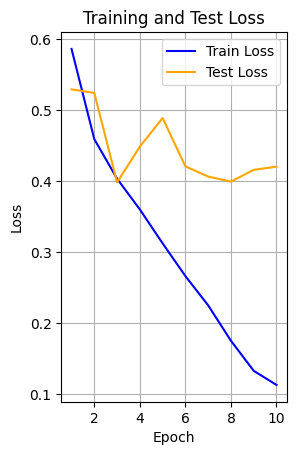

In [26]:
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss", color="blue")
plt.plot(range(1, EPOCHS + 1), test_losses, label="Test Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()
plt.grid(True)

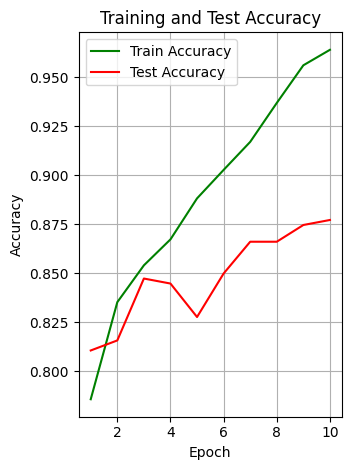

In [27]:
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accuracies, label="Train Accuracy", color="green")
plt.plot(range(1, EPOCHS + 1), test_accuracies, label="Test Accuracy", color="red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("pomegranate_training_plots.png")
plt.show()
logger.info("Training plots saved to pomegranate_training_plots.png")


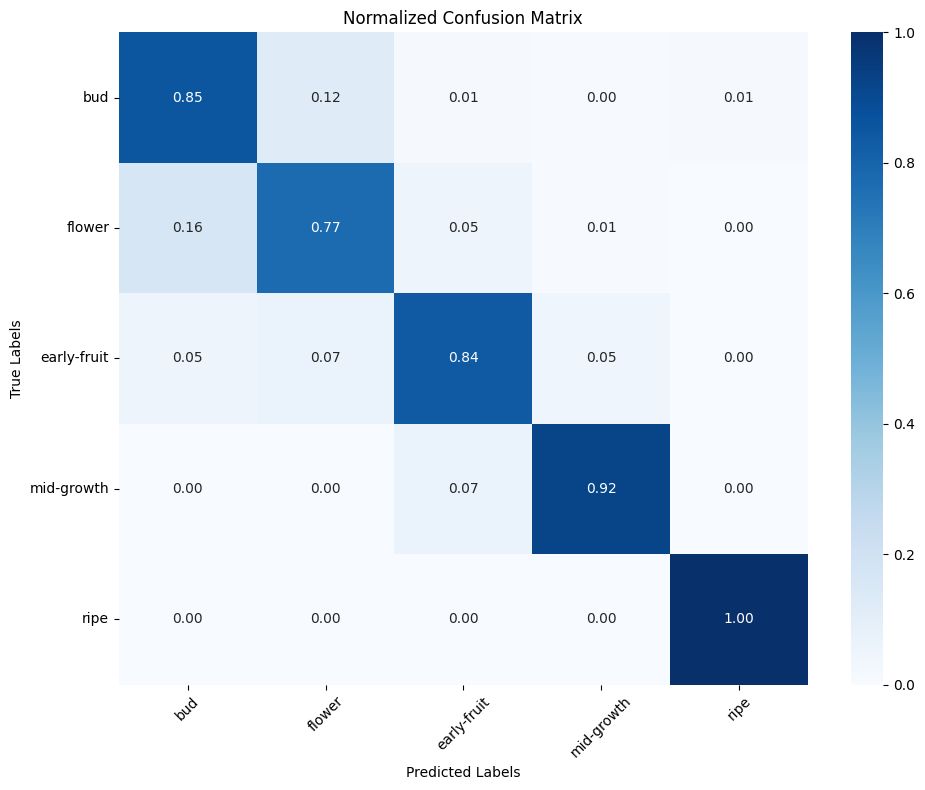

In [28]:
# Generate and plot confusion matrix
cm = confusion_matrix(test_true, test_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("pomegranate_confusion_matrix.png")
plt.show()
logger.info("Confusion matrix saved to pomegranate_confusion_matrix.png")